# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Winter term 2020/21
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
* Due date: **Tue, 15. Dec 20, 2:15pm**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [5]:
# TODO import utils.py
!wget -qO utils.py https://raw.githubusercontent.com/atopion/deep-learning/master/utils.py

import utils

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [6]:
# TODO define device

device = utils.get_device()

# Get number of cpus to use for faster parallelized data loading
use_cpus = os.cpu_count()
print(use_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4
2 CPUs available


In [7]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders

seed = 1799686
val_fraction = 0.2

trainset, testset, dataset_mean, dataset_std = utils.grab_data(data_dir=data_dir, num_cpus=use_cpus)

trainset, valset = utils.generate_train_val_data_split(trainset=trainset, split_seed=seed, val_frac=val_fraction)

trainloader, valloader, testloader = utils.init_data_loaders(trainset, valset, testset, batch_size=batch_size, num_cpus=use_cpus)

Extracting data/cifar-10-python.tar.gz to data

Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [8]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

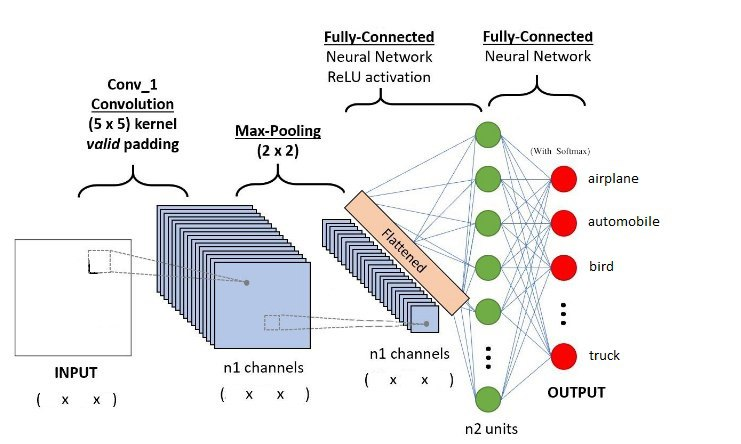

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

**Answers**  
1. As the images are again from CIFAR-10, the image dimensions are 32x32x3
2. Feature maps after the conv. layer: 28x28x1
3. Feature maps after the max-pooling layer: 14x14x1
4. N1: 32, N2: 512
5. Parameters for a convolutional layer: (input_chan × kernel_x × kernel_y × output_chan).  
    => conv_1 = 3 × 5 × 5 × 32 = 2400

**Your answers here**

In [9]:
# Helper
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x

# TODO define model
class CNN_Model(nn.Module):
    def __init__(self, num_in_channels, num_classes):
        """Initialize model.

        Args:
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
        """

        # Call to super
        super(CNN_Model, self).__init__()

        n1 = 32
        n2 = 512
        n3 = num_classes

        x = 6272 # = 14 * 14 * 32

        self.model = nn.Sequential(
            nn.Conv2d(num_in_channels, n1, 5, stride=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(x, n2),
            nn.ReLU(),
            nn.Linear(n2, n3)
        )

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """

        return self.model(x)

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

###**Train the CNN model for 10 epochs**

Finished training after 102 seconds.
Lowest  validation loss:     0.9952469497919083 (in epoch 5)
Highest validation accuracy: 0.6698 (in epoch 10)


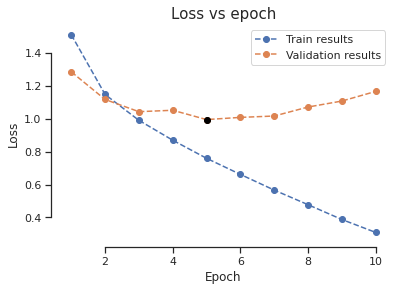

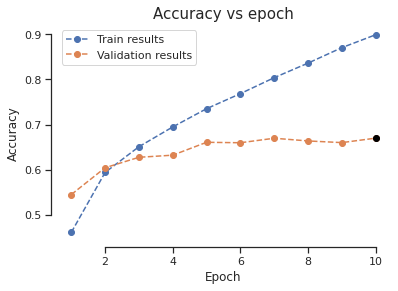

In [10]:
# TODO train and plot
model = CNN_Model(num_in_channels=3, num_classes=10)
utils.doTraining(
    model = model,
    title = "Train the CNN model for 10 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 10,
    lr = 0.001
)

#### **TODO**
Compare results to MLP. What can you observe?

**Answer**: Even when trained only for 10 epochs, the CNN gives much better results with a validation accuracy 0.6742 after only 7 epochs and a validation loss of 0.97. Both of which were completely unreachable with the MLP network.

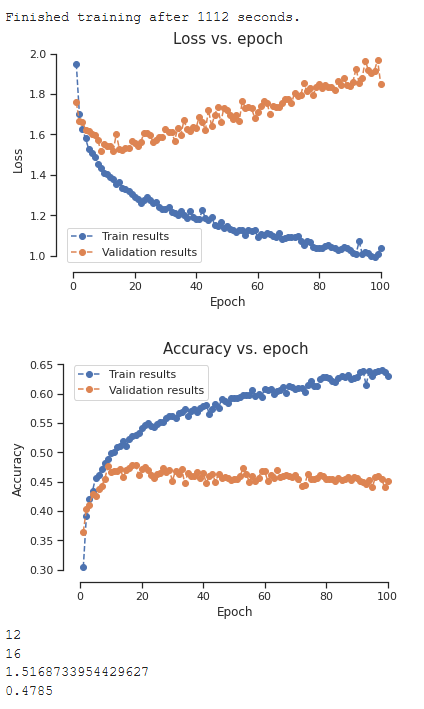

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

###**Train the CNN model for 60 epochs**

Finished training after 617 seconds.
Lowest  validation loss:     0.9655294194817543 (in epoch 7)
Highest validation accuracy: 0.6824 (in epoch 56)


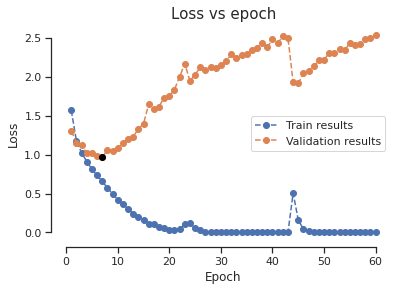

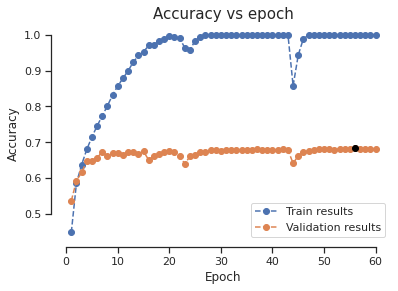

In [11]:
# TODO train and plot
model = CNN_Model(num_in_channels=3, num_classes=10)
utils.doTraining(
    model = model,
    title = "Train the CNN model for 60 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 60,
    lr = 0.001
)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Answers**:
1. The model overfits (easily visible, as the training accuracy reaches 1.0)
2. We could add additional convolutional layers to give the model more free parameters


## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

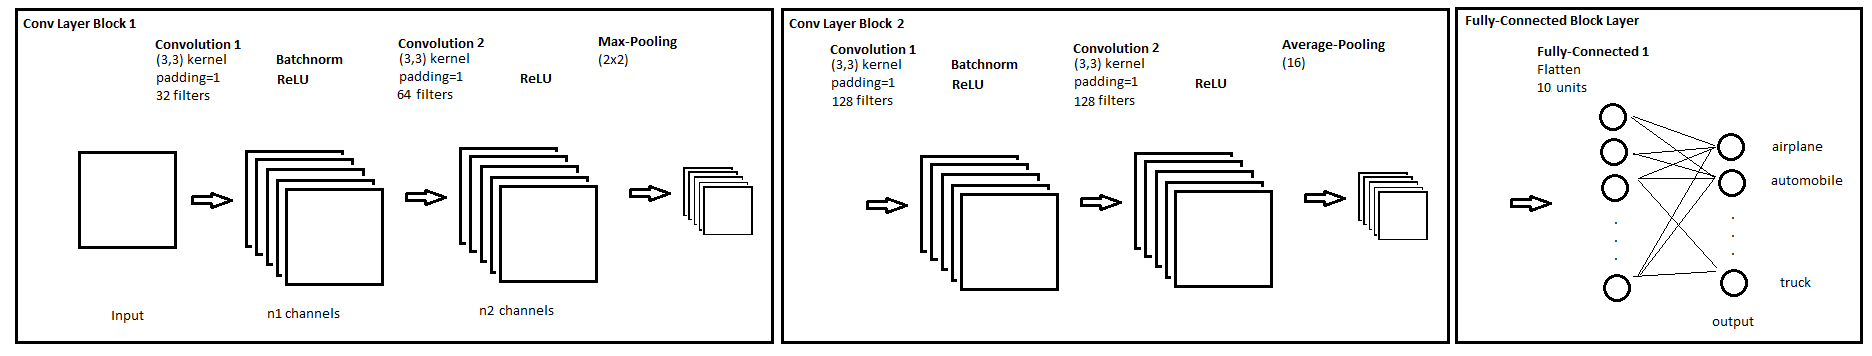

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Answers**:
1. Padding means adding zeros around the input image. This can control the dimension change of the feature maps in convoltional layers. Options are "valid" = no padding or "same" = padding just as much so the feature map size stays the same.
2. With a kernel of 3x3, padding=1 means a "same" padding, which means the feature maps do not shrink and stay at their size
3. M = (N - k + 2P)/s + 1 = (32 - 3 + 2*1)/1 + 1 = 32
4. M = (N - k + 2P)/s + 1 = (32 - 3 + 2*1)/1 + 1 = 32
5. 1 + (k_l1 - 1) + (k_l2 - 1) = 1 + (3-1) + (3-1) = 5
6. 128
7. conv_1: 3 x 3 x 3 x 32 = 864, conv_2: 32 x 3 x 3 x 64 = 18432, batchnorm, max pooling and relu: None. Therefore Conv Layer block 1 has a total number of parameters of 19296

In [12]:
#TODO define model 2
class CNN_Model_2(nn.Module):
    def __init__(self, num_in_channels, num_classes):
        """Initialize model.

        Args:
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
        """

        # Call to super
        super(CNN_Model_2, self).__init__()

        n1 = 32
        n2 = 64
        n3 = 128

        x = 128 # = 8 x 8 x 128

        self.model = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(num_in_channels, n1, 3, stride=1, padding=1),
            nn.BatchNorm2d(n1),
            nn.ReLU(),
            nn.Conv2d(n1, n2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            # Convolutional Layer Block 2
            nn.Conv2d(n2, n3, 3, stride=1, padding=1),
            nn.BatchNorm2d(n3),
            nn.ReLU(),
            nn.Conv2d(n3, n3, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(16),

            # Fully Connected Block Layer
            nn.Flatten(),
            nn.Linear(x, num_classes)
        )

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """

        return self.model(x)

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

**Answer:**
- In these results, we see that the validation accuracy follows the training accuracy closely, which hints that this model generalizes much better and does not overfit as much.
- We also see a high fluctuation in the validation accuracy, which might be the result of the (comparatively) high learning rate.

###**Second CNN model trained for 30 epochs**

Finished training after 410 seconds.
Lowest  validation loss:     0.961571429669857 (in epoch 29)
Highest validation accuracy: 0.6641 (in epoch 29)


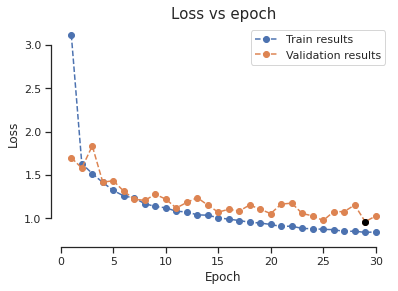

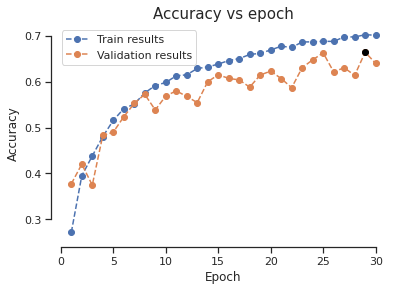

In [13]:
# TODO train and plot
model = CNN_Model_2(num_in_channels=3, num_classes=10)
utils.doTraining(
    model = model,
    title = "Second CNN model trained for 30 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 30,
    lr = 0.1
)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

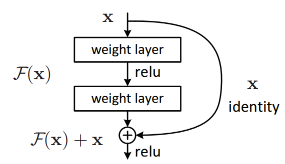

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Answers:**
- Skip connections are able to bypass layers in the architecture that would actually hurt the performance of the model. We can thus train very deep NNs without the problems that are often encountered with those architectures (vanishing/exploding gradients).
- Calling the desired underlying mapping that we want at our layer f(x). In a residual block, the layer has to learn the residual mapping f(x)-x (as the identity mapping x passes around the layer). If we want to have an identity mapping f(x) = x, the model simply has to set the weights in the bypassed layer to zero, which is easier for the model to learn.
- They have been shown to work particularly well with very deep CNN architectures.


#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model; the class contains the following methods:
    - init
    - make_layer
    - forward
- train the model
- plot results

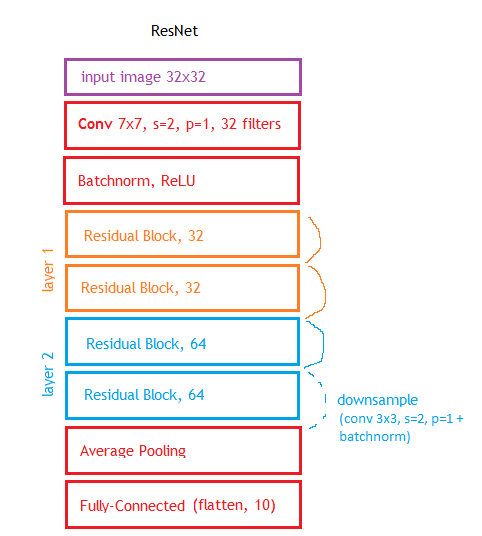
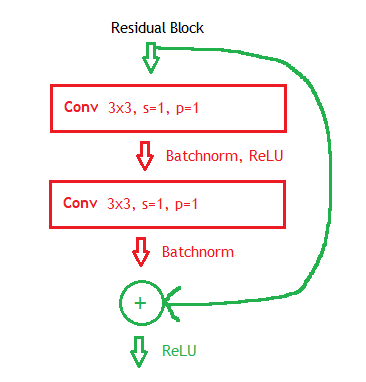

In [14]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    '''
        Conv--> Batchnorm-->ReLu-->Conv-->Batchnorm--> 
        Only downsample if needed
    '''
    def __init__(self, in_channels, out_channels, stride_1=1, stride_2=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # TODO
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride_1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, stride=stride_2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = downsample
        self.final_act  = nn.ReLU()
        
        
    def forward(self, x):
        # TODO
        identity = x

        out = self.block(x)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out =  self.final_act(out)

        return out

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        # TODO
        n0 = 3
        n1 = 32
        n2 = 64
        x  = 64

        downsample = nn.Sequential(
            nn.Conv2d(n1, n2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n2)
        )

        self.model = nn.Sequential(
            # Input
            nn.Conv2d(n0, n1, kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(n1),
            nn.ReLU(),

            # Layer 1
            ResidualBlock(n1, n1, stride_1=1, stride_2=1, downsample=None),
            ResidualBlock(n1, n1, stride_1=1, stride_2=1, downsample=None),

            # Layer 2
            ResidualBlock(n1, n2, stride_1=2, stride_2=1, downsample=downsample),
            ResidualBlock(n2, n2, stride_1=1, stride_2=1, downsample=None),

            # Fully Connected Block Layer
            nn.AvgPool2d(7),
            nn.Flatten(),
            nn.Linear(x, num_classes)
        )

        
    def make_layer(self, block, out_channels, blocks, stride=1, padding=0):
        # TODO
        pass

    
    def forward(self, x):
        # TODO
        out = self.model(x)
        return out

###**ResNet model trained for 30 epochs**

Finished training after 346 seconds.
Lowest  validation loss:     0.8459102377295494 (in epoch 12)
Highest validation accuracy: 0.7463 (in epoch 26)


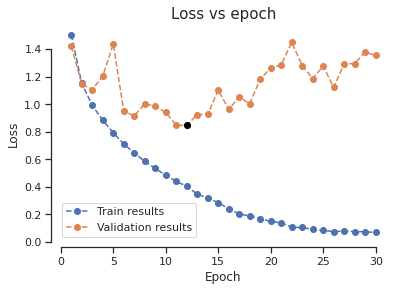

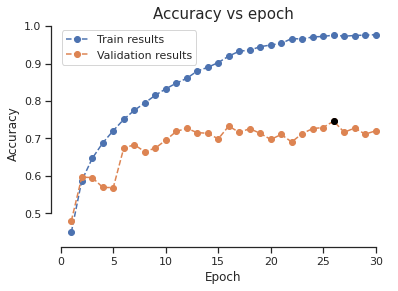

In [16]:
# TODO train and plot
model = ResNet(None, None)
utils.doTraining(
    model = model,
    title = "ResNet model trained for 30 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 30,
    lr = 0.001
)

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Answers:**
-
- With ResNet, the training time decreased from 410 seconds to 346 seconds, so training ResNets is less expensive.

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Answers:**
1. A gamma value of 0.1 means that the learning rate is divided by 10 in each step. We see that this (combined with a step size of 1) leads to a network which very quickly stops training, giving limited results.
2. A gamma value of 0.9 means the learning rate is multiplied by 0.9 every step. We see that, compared to a gamma of 0.1, this network trains much more since the learning rate decay is slower and, compared to the fixed learning rate ResNet, slowes down overfitting, resulting in the best result yet.
3. A larger step size or a higher gamma is needed for a good learning rate schedule.

In [17]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

# Changed within the utils.py file

###**ResNet model with StepLR (gamma 0.1) trained for 30 epochs**

Finished training after 347 seconds.
Lowest  validation loss:     1.0738829165697097 (in epoch 8)
Highest validation accuracy: 0.6159 (in epoch 18)


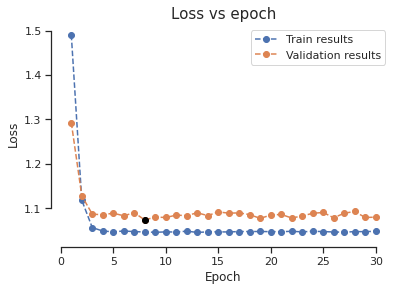

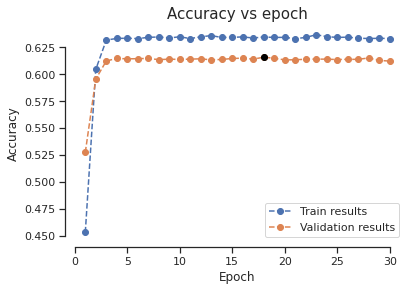

In [18]:
# TODO train and plot with step size 1, gamma 0.1
model = ResNet(None, None)
utils.doTraining(
    model = model,
    title = "ResNet model with StepLR (gamma 0.1) trained for 30 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 30,
    lr = 0.001,
    lr_scheduler = StepLR,
    lr_step_size = 1,
    lr_gamma = 0.1
)

###**ResNet model with StepLR (gamma 0.9) trained for 30 epochs**

Finished training after 343 seconds.
Lowest  validation loss:     0.7855042293667793 (in epoch 11)
Highest validation accuracy: 0.7406 (in epoch 11)


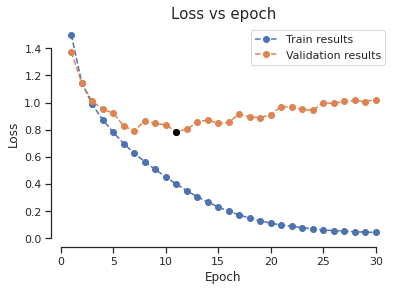

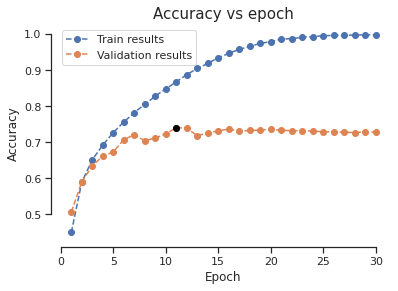

In [19]:
# TODO train and plot with step size 1, gamma 0.9
model = ResNet(None, None)
utils.doTraining(
    model = model,
    title = "ResNet model with StepLR (gamma 0.9) trained for 30 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 30,
    lr = 0.001,
    lr_scheduler = StepLR,
    lr_step_size = 1,
    lr_gamma = 0.9
)

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Answers:**
1. No
2. The validation accuracy is with this method very fluctuative.

###**ResNet model with ReduceLROnPlateau trained for 30 epochs**

Finished training after 345 seconds.
Lowest  validation loss:     0.942459163069725 (in epoch 18)
Highest validation accuracy: 0.6842 (in epoch 21)


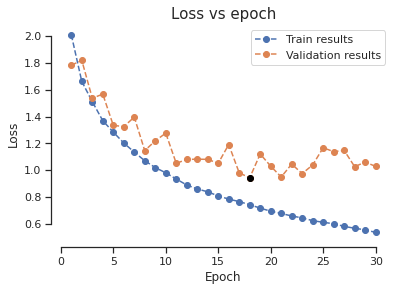

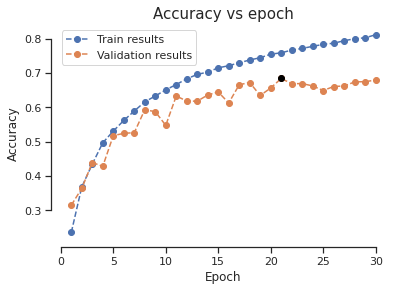

In [20]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.
# Paper: LR starts at 0.1, divided by 10 once the error plateaus, optimizer: SDG

model = ResNet(None, None)
utils.doTraining(
    model = model,
    title = "ResNet model with ReduceLROnPlateau trained for 30 epochs",
    trainloader = trainloader,
    valloader = valloader,
    device = device,
    epochs = 30,
    lr = 0.1,
    lr_scheduler = ReduceLROnPlateau
)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [21]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [22]:
# TODO do transfer learning with resnet on cifar10